# Modèle de classification

Si une image est une empreinte de pas d'animal ou non

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import io
from keras import layers, models, losses
from PIL import Image
import requests as re
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2025-01-22 19:30:37.201536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 19:30:37.210498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737570637.220107 2534346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737570637.223006 2534346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 19:30:37.233980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
df_lapin = pd.read_csv('/home/shared/lapin.txt', sep='\t', on_bad_lines='skip')
df_lynx = pd.read_csv('/home/shared/lynx.txt', sep='\t', on_bad_lines='skip')
df_puma = pd.read_csv('/home/shared/puma.txt', sep='\t', on_bad_lines='skip')

df_animals = pd.concat([df_lapin, df_lynx, df_puma], axis=0)

# On utilise la fonction sample pour mélanger les données,
# l'argument frac=1 signfique que nous retournous toutes les lignes dans un ordre randomisé
df_animals.sample(frac=1)

,gbifID,type,format,identifier,references,title,description,source,audience,created,creator,contributor,publisher,license,rightsHolder
97948,4145593393,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/277531296,NaN,NaN,NaN,NaN,2023-05-07T08:40:35-07:00,David Torres,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,David Torres
160806,3383894982,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/147098619,NaN,NaN,NaN,NaN,2021-06-06T19:29Z,Dave Crawford,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Dave Crawford
145009,4935706085,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/302853502,NaN,NaN,NaN,NaN,2023-07-22T17:31:34Z,Sandra Power,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Sandra Power
82531,2999109306,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/8335256,NaN,NaN,NaN,NaN,2017-06-09T19:32:25-07:00,Jami Gramore,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Jami Gramore
41468,4606663092,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/363329265,NaN,NaN,NaN,NaN,2022-09-30T11:30Z,chelsiechanel,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,chelsiechanel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26566,3355177242,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/155778309,NaN,NaN,NaN,NaN,2021-09-06T13:10:40-07:00,Dario Taraborelli,NaN,iNaturalist,http://creativecommons.org/publicdomain/zero/1.0/,Dario Taraborelli
155786,2864887371,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/95137479,NaN,NaN,NaN,NaN,2020-09-13T20:58:34Z,Alice Thompson,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Alice Thompson
166336,3888880297,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/220704743,NaN,NaN,NaN,NaN,2022-06-04T20:32:34-07:00,Lindsey G.,NaN,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Lindsey G.
4600,4420933321,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/323621370,NaN,NaN,NaN,NaN,2023-05-22T11:07:00Z,hectorlopez02,NaN,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,hectorlopez02


In [3]:
def get_image(url, limit=350):
    # Limit the number of images to download
    if len(os.listdir('/home/shared/Random_animals')) > limit:
        return
    
    response = re.get(url)
    img = Image.open(io.BytesIO(response.content))

    # Keep original.jpg
    img_name = url.split("/")[-1]
    # Add random number to the name
    img_name = img_name.split(".")[0] + str(random.randint(0, 10000)) + '.' + img_name.split(".")[1]

    # Save the image to disk
    img.save(f'/home/shared/Random_animals/{img_name}')

df_animals["identifier"].apply(lambda x: get_image(x))

0        None
1        None
2        None
3        None
4        None
         ... 
16917    None
16918    None
16919    None
16920    None
16921    None
Name: identifier, Length: 254803, dtype: object

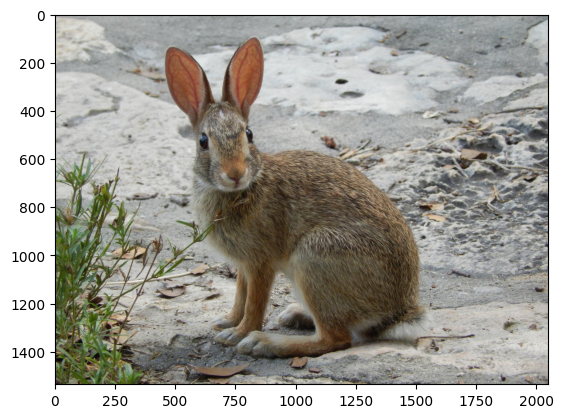

In [7]:
plt.imshow(Image.open("/home/shared/Random_animals/original366.jpg"))